# Thermal-Hydraulics of a pin
This notebook implements the thermal-hydraulic analysis of a pin inside a nuclear reactor. The main output will be the temperature at different heights for all the materials (water, cladding, helium and fuel), returned from the following equations
\begin{equation}
\left\{
\begin{array}{ll}
    \rho\,c_p\,\left(\frac{\partial T}{\partial t}+\mathbf{u}\cdot \nabla T\right)-\nabla\cdot (k\nabla T)=q'''(x) & \mathbf{x}\in\Omega\\  & \\
    T= T_0 & t=0 \\
    T=T_D & \mathbf{x}\in\Gamma_o\cup\Gamma_{in}\\
    \displaystyle\frac{\partial T}{\partial \mathbf{n}}=0 & \mathbf{x}\in\partial \Omega/\Gamma_o\cup\Gamma_{in}
\end{array}
\right.
\end{equation}
in which the velocity is different from $\mathbf{0}$ only in the water and the power generation is different from 0 only in the fuel.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

import numpy as np
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator, interp2d, interp1d
import tqdm

import dolfinx
from dolfinx import fem
from dolfinx.fem import (Constant, Function, FunctionSpace, assemble_scalar, 
                        dirichletbc, form, locate_dofs_topological, locate_dofs_geometrical)
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import XDMFFile, gmshio
from dolfinx import mesh

import ufl
from ufl import (FacetNormal, FiniteElement, TestFunction, TrialFunction, VectorElement,
                 div, dot, grad, ds, dx, lhs, rhs, inner, nabla_grad)

from mpi4py import MPI
from petsc4py import PETSc

Some important tools must be defined: the inner product in $L^2$ and $H^1$
\begin{equation}
\left\langle u,\, v\right\rangle_{L^2} = \int_\Omega u\,v\,d\Omega\qquad \qquad
\left\langle u,\, v\right\rangle_{H^1} = \int_\Omega \nabla u\cdot\nabla v\,d\Omega
\end{equation}
from which the correspondent norms are derived
\begin{equation}
\|u\|_{L^2} = \sqrt{\left\langle u,\, u\right\rangle_{L^2}}\qquad \qquad 
\|u\|_{H^1} = \sqrt{\left\langle u,\, u\right\rangle_{H^1}}
\end{equation}
In addition, the $L^\infty$ norm is defined
\begin{equation}
\|u\|_{L^\infty} = \max\limits_{x\in\Omega} |u(x)|
\end{equation}

In [2]:
class norms():
  def __init__(self, funSpace, domain):
    self.domain = domain
    self.trial = ufl.TrialFunction(funSpace)
    self.test  = ufl.TestFunction(funSpace)

    self.L2inner = inner(self.trial, self.test) * dx
    self.H1inner = inner(grad(self.trial), grad(self.test)) * dx

  def L2norm(self, u):
    repl_form = form(ufl.replace(self.L2inner, {self.trial: u, self.test: u}))
    return np.sqrt( self.domain.comm.allreduce(assemble_scalar(repl_form), op=MPI.SUM) )
    
  def H1norm(self, u):
    repl_form = form(ufl.replace(self.H1inner, {self.trial: u, self.test: u}))
    return np.sqrt( self.domain.comm.allreduce(assemble_scalar(repl_form), op=MPI.SUM) )
    
  def L2innerProd(self, u, v):
    repl_form = form(ufl.replace(self.L2inner, {self.trial: u, self.test: v}))
    return self.domain.comm.allreduce(assemble_scalar(repl_form), op=MPI.SUM)

  def Linftynorm(self, u):
    return self.domain.comm.allreduce(np.max(np.abs(u.x.array)), op = MPI.MAX)

At first, the geometry and the mesh are imported from "pin2D.msh".

In [3]:
gdim = 2

from dolfinx.io import XDMFFile, gmshio

domain, ct, ft = gmshio.read_from_msh("pin2Dsimple.msh", MPI.COMM_WORLD, gdim = gdim)

fuel_marker   = 1
helium_marker = 2
clad_marker   = 3
water_marker  = 4

outer_marker = 10
sym_marker = 20
top_marker = 30
bottom_marker = 40
inlet_marker = 50

Info    : Reading 'pin2Dsimple.msh'...
Info    : 27 entities
Info    : 19600 nodes
Info    : 20003 elements
Info    : Done reading 'pin2Dsimple.msh'


### Definition of the functional space and boundary conditions
The following lines are used to import all the necessary libraries, define the functional space and the boundary conditions.

In [4]:
tdim = domain.topology.dim

fdim = tdim - 1

domain.topology.create_connectivity(fdim, tdim)

## Functional Spaces
scalarElement = ufl.FiniteElement("CG", domain.ufl_cell(), 1)
V = FunctionSpace(domain, scalarElement)

### Define parameter functions on the different regions
Since there are 4 subdomains in $\Omega$ (i.e., fuel, helium, cladding and water) the values of the parameters changes according to the region, therefore proper functions should be defined in a Discountinuous Galerkin Finite Element space.

In [5]:
class parameterFun():
    def __init__(self, cell_tag, funSpace: FunctionSpace):
        self.regionMarker = []
        self.cell_tag = cell_tag
        self.funSpace = funSpace

    def appendRegion(self, new_marker):
        self.regionMarker.append(new_marker)
        
    def assign(self, value_vec):
        fun = Function(self.funSpace)
        
        for idx in range(len(self.regionMarker)):
            regionI = self.regionMarker[idx]
            region_cells = self.cell_tag.find(regionI)
            fun.x.array[region_cells] = np.full_like(region_cells, value_vec[idx], dtype=PETSc.ScalarType)
        
        return fun
    
    
V_parameters = FunctionSpace(domain, ("DG", 0))
parameters = parameterFun(ct, V_parameters)

parameters.appendRegion(fuel_marker)
parameters.appendRegion(helium_marker)
parameters.appendRegion(clad_marker)
parameters.appendRegion(water_marker)

k_value   = np.array([16, 0.15, 235, 0.63]) / 100. # W/cm-K # water value at p = 1 bar, T = 40 C
rho_cp_value = np.array([10.29769 * 0.365, 0.001598 * 5.188, 2.713 * 0.89, 0.99655748249966 * 4.1811010618968]) # g / cm3 * J / g / K

is_fuel   = np.array([1., 0., 0., 0.]) 
is_helium = np.array([0., 1., 0., 0.]) 
is_clad   = np.array([0., 0., 1., 0.]) 
is_water  = np.array([0., 0., 0., 1.])

TD = 25 + 273.15
T0_value = np.array([100, 100, 100, 25.]) + 273.15

### Variational formulation
Given the problem in strong form, we can define the variational formulation starting from the following functional spaces
\begin{equation}
\mathcal{V}=\left\{ v\in\mathcal{H}^1(\Omega)\,:\,\left. v\right|_{\Gamma_o}=T_o\right\}\qquad
\mathcal{V}_0=\left\{ v\in\mathcal{H}^1(\Omega)\,:\,\left. v\right|_{\Gamma_o}=0\right\}
\end{equation}
Using the integration by parts the weak formulation reads:
\begin{equation}
    \rho\,c_p\,\int_{\Omega} \left(\frac{\partial T}{\partial t}+\mathbf{u}\cdot\nabla T\right)\, v\,d\Omega + \int_\Omega k\nabla T\cdot\nabla v\,d\Omega =  \int_\Omega q''' \, v\,d\Omega
\end{equation}
This results in the finite dimensional space in a system of ODEs. The time discretisation is performed using an implicit Euler scheme, thus given the IC at each time step the problem to be solved is the following

\begin{equation}
    \int_{\Omega}\rho\,c_p\, \left(\frac{T^{(k+1)}}{\Delta t}+\mathbf{u}\cdot\nabla T^{(k+1)}\right)\, v\,d\Omega + \int_\Omega k\nabla T^{(k+1)}\cdot\nabla v\,d\Omega =  \int_\Omega \left(\frac{T^{(k)}}{\Delta t} +q'''^{(k+1)} \right)\, v\,d\Omega
\end{equation}
where the superscript $^{(k+1)}$ denotes the value at time $t=t^{(k+1)}$.

In [12]:
class thermal():
    def __init__(self, domain, funSpace, parameterClass, k_value, rho_cp_value, is_fuel, is_water):

        self.domain = domain
        self.funSpace = funSpace

        self.parameterClass = parameterClass

        self.k        = self.parameterClass.assign(k_value)
        self.rho_cp   = self.parameterClass.assign(rho_cp_value)
        self.is_fuel  = self.parameterClass.assign(is_fuel)
        self.is_water = self.parameterClass.assign(is_water)

        self.T = ufl.TrialFunction(self.funSpace)
        self.v = ufl.TestFunction(self.funSpace)
        
    def assignBC(self, T_D, ft, inlet_marker, outer_marker):
        self.TD = fem.Constant(self.domain, PETSc.ScalarType(T_D))

        bc_inlet  = dirichletbc(self.TD, locate_dofs_topological(self.funSpace, fdim, ft.find(inlet_marker)),
                                self.funSpace)
        bc_outer  = dirichletbc(self.TD, locate_dofs_topological(self.funSpace, fdim, ft.find(outer_marker)),
                                self.funSpace)
        self.bc = [bc_inlet, bc_outer]
    
    def assemble(self, ux, uy, dt, IC_value):
        self.ux = ux
        self.uy = uy

        self.t  = 0. 
        self.dtValue = dt
        self.dt = fem.Constant(domain, PETSc.ScalarType(self.dtValue))

        self.Told = Function(self.funSpace)
        self.Told.interpolate(self.parameterClass.assign(IC_value))

        self.q    = Function(self.funSpace)
        
        self.left_side  = (inner(self.rho_cp * self.T / self.dt, self.v) +
                           inner(self.rho_cp * self.is_water * dot(ufl.as_vector([self.ux, self.uy]), grad(self.T)), self.v) +
                           inner(self.k * grad(self.T), grad(self.v)) ) * dx
        
        # Stabilisation: SUPG
        self.P0 = FunctionSpace(self.domain, ("DG", 0))
        self.uK = Function(self.P0)
        self.uK.interpolate(fem.Expression( self.rho_cp * ufl.algebra.Power(self.ux ** 2 + self.uy ** 2, 0.5),
                                            self.P0.element.interpolation_points() ))

        self.PeK = Function(self.P0)
        self.PeK.interpolate(fem.Expression(1e-12 + self.uK * ufl.CellDiameter(self.domain) / 2. / self.k,
                                            self.P0.element.interpolation_points() ))
        
        self.tauK = Function(self.P0)
        self.tauK.interpolate(fem.Expression(ufl.CellDiameter(self.domain) / 2. / (self.uK) * ( 1./ufl.mathfunctions.Tanh(self.PeK)-1./self.PeK),
                                             self.P0.element.interpolation_points() ))

        self.left_side += self.tauK * inner(self.is_water * self.rho_cp * dot(ufl.as_vector([self.ux, self.uy]), grad(self.T)), 
                                            self.is_water * self.rho_cp * dot(ufl.as_vector([self.ux, self.uy]), grad(self.v))) * dx

        self.right_side = inner(self.rho_cp * self.Told / self.dt + self.is_fuel * self.q, self.v) * dx
        
        self.a = form(self.left_side)
        self.L = form(self.right_side)
        
        self.A = fem.petsc.assemble_matrix(self.a, bcs=self.bc)
        self.A.assemble()
        self.b = fem.petsc.create_vector(self.L)
        
        self.solver = PETSc.KSP().create(self.domain.comm)
        self.solver.setOperators(self.A)
        self.solver.setType(PETSc.KSP.Type.GMRES)
        self.pc = self.solver.getPC()
        self.pc.setType(PETSc.PC.Type.ILU)
        # self.solver.setType(PETSc.KSP.Type.BCGS)
        # self.pc = self.solver.getPC()
        # self.pc.setType(PETSc.PC.Type.JACOBI)
    
    def extract1D_y(self, T, L, R):
        
        Ny = 100
        x_grid = np.array([-L/2+0.5, -L/4, -L/8, 0., L/8, L/4, L/2-0.5])
        Nx = len(x_grid)
        y_grid = np.linspace(0, R, Ny)
        
        for ii in range(Nx):
            points = np.zeros((3, Ny))
            points[0, :] = x_grid[ii]
            points[1, :] = y_grid

            bb_tree = dolfinx.geometry.BoundingBoxTree(self.domain, self.domain.topology.dim)
            cells = []
            points_on_proc = []
            cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
            colliding_cells = dolfinx.geometry.compute_colliding_cells(self.domain, cell_candidates, points.T)
            for i, point in enumerate(points.T):
                if len(colliding_cells.links(i))>0:
                    points_on_proc.append(point)
                    cells.append(colliding_cells.links(i)[0])
            xPlot = np.array(points_on_proc, dtype=np.float64)
            
            if ii == 0:
                Ty = np.zeros((xPlot.shape[0], Nx+1))
                Ty[:, 0] = xPlot[:, 1]
            Ty[:, ii+1] = T.eval(xPlot, cells).flatten()
        
        return Ty 
    
    def solve(self, power_fun, T, s, L, R, norm): 
        # power function should be a callable interpolant
        self.q.interpolate(lambda x: power_fun(x[0], x[1] * np.exp(s * self.t)))
        
        solution = Function(self.funSpace)
        solution.x.array[:] = self.Told.x.array
        
        # Radial T
        Ty = []
        
        # Regional average
        T_ave_fuel   = []
        T_ave_water  = []

        xdmf = XDMFFile(domain.comm, "T.xdmf", "w")
        xdmf.write_mesh(domain)
        solution.name = "T"
        xdmf.write_function(solution, self.t)

        progress = tqdm.tqdm(desc="Solving PDE", total=int(T/self.dtValue))
            
        while (self.t < T): 
            self.t += self.dtValue
            
            with self.b.localForm() as loc:
                loc.set(0)
            fem.petsc.assemble_vector(self.b, self.L)
            fem.petsc.apply_lifting(self.b, [self.a], [self.bc])
            self.b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            fem.petsc.set_bc(self.b, self.bc)
            
            self.solver.solve(self.b, solution.vector)
            solution.x.scatter_forward()
        
            self.Told.x.array[:] = solution.x.array
            xdmf.write_function(solution, self.t)
            progress.update(1)
            
            Ty.append(self.extract1D_y(solution, L, R))
            T_ave_fuel.append(norm.L2innerProd(self.is_fuel * solution, 1.) / 
                              norm.L2innerProd(self.is_fuel, 1.))
            T_ave_water.append(norm.L2innerProd(self.is_water * solution, 1.) / 
                               norm.L2innerProd(self.is_water, 1.))
        xdmf.close()
        return Ty, T_ave_fuel, T_ave_water
    

Let us solve the problem for some power distribution.

In [13]:
TH = thermal(domain, V, parameters, k_value, rho_cp_value, is_fuel, is_water)
TH.assignBC(TD, ft, inlet_marker, outer_marker)

In [14]:
ux = Function(V)
uy = Function(V)

clad_or = 1.88
R = 4.36/2
L = 38

a = -1. / (R - clad_or)**2
b = 2  / (R - clad_or)
ux_fun = lambda x, y: a * (y - clad_or)**2 + b * (y - clad_or) + 0.0 * x
uy_fun = lambda x, y: 0.0 * x * y

ux.interpolate(lambda x: ux_fun(x[0],x[1]))
uy.interpolate(lambda x: uy_fun(x[0],x[1]))

dt = 1e-2
TH.assemble(ux, uy, dt, T0_value)

In [15]:
power_fun = lambda x, y: 100 * np.cos(np.pi*(x/L)) + 0.0 * y
s = 0.5
T = 5
Vnorms = norms(V, domain)
Ty, T_ave_fuel, T_ave_water = TH.solve(power_fun, T, s, L, R, Vnorms)

Solving PDE: 501it [01:43,  4.85it/s]                                           


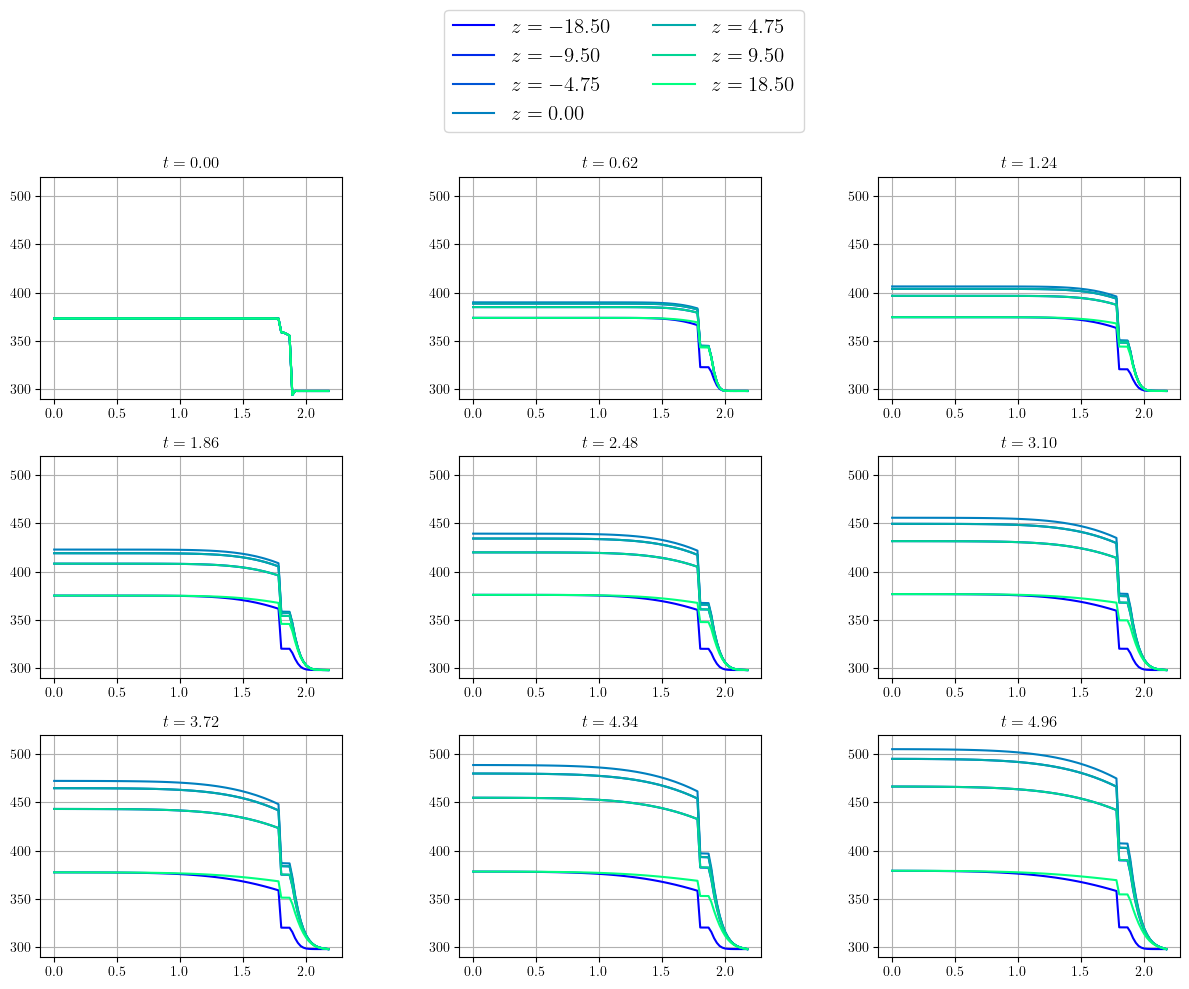

In [10]:
Nt = int(T/dt)
t_idx_to_plot = np.arange(0, Nt, int(Nt/8))
t = np.arange(0,T+dt/2, dt)
x_grid = np.array([-L/2+0.5, -L/4, -L/8, 0., L/8, L/4, L/2-0.5])

fig = plt.figure(figsize = (12,10))
for ii in range(len(t_idx_to_plot)):
    plt.subplot(3, 3, ii+1) 
    color = iter(cm.winter(np.linspace(0, 1, len(x_grid))))
    for jj in range(len(x_grid)):
        c = next(color)
        plt.plot(Ty[t_idx_to_plot[ii]][:, 0], Ty[t_idx_to_plot[ii]][:, jj+1], 
                 label = '$z = {:.2f}'.format(x_grid[jj])+'$', c=c)

    if ii == 1:
        plt.legend(fontsize = 15, ncol = 2, loc =(-0.05, 1.2))
    # plt.xlabel(r'$z$', fontsize = 15)
    # plt.ylabel(r'$T$', fontsize = 15)
    plt.grid(which='major',linestyle='-')
    plt.grid(which='minor',linestyle='--')
    plt.ylim(290, 520)
    plt.title('$t={:.2f}'.format(t[t_idx_to_plot[ii]])+'$')
    
plt.tight_layout()
fig.savefig('Radial.pdf', format='pdf', dpi=600, bbox_inches='tight')

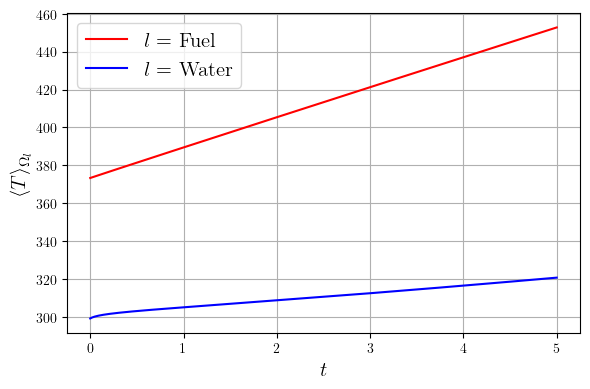

In [11]:
fig = plt.figure(figsize = (6,4))
plt.plot(t, T_ave_fuel,'r', label = r'$l =$ Fuel')
plt.plot(t, T_ave_water,'b', label = r'$l =$ Water')        
plt.legend(fontsize = 15)
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$\langle T\rangle_{\Omega_l}$', fontsize = 15)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.tight_layout()
fig.savefig('RegAverage_time.pdf', format='pdf', dpi=600, bbox_inches='tight')